In [6]:
## importing all libraries for our models

# pandas
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tensorflow.keras
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, LSTM
from keras.layers import Concatenate, concatenate 
# Concatenate returns Concatenate object (layers), concatenate returns Tensor object (arrays)
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
#from tensorflow.keras.utils import plot_model


# numpy
import numpy as np
from numpy import random

# sklearn
import sklearn

# sklearn for pipeline mixins
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn for data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# sklearn for models
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.preprocessing import normalize

# sklearn for model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import sklearn.metrics.cluster as smc

# matplotlib.pyplot for plotting
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import os

# misc
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import pydot
import graphviz
from PIL import Image
import numpy as np
from numpy import random
import glob
import rasterio as rio
import scipy.io as sio
import glob

In [49]:
def process_images(folder, num_days):
    snapshots = glob.glob(folder)
    
    array = np.load(snapshots[0])
    
    for file in snapshots[1:int(num_days)]:
        array = np.append(array, np.load(file), axis = 0)
    array = array.reshape(1, int(num_days), 100, 100)
    return array

In [52]:
# NOTE FOR DATA COLLECTION: make .npy shapes much larger, can be closer to 100x100
imerg_precip = process_images('/home/fun/data/AL192012/*.npy', 5)
imerg_precip.shape

(1, 5, 100, 100)

In [53]:
# normalize data

scaler = StandardScaler()

scaler.fit(imerg_precip)

scaled_precip = scaler.transform(imerg_precip) # see scikit-learn documentation for details

type(scaled_precip)

ValueError: Found array with dim 4. StandardScaler expected <= 2.

In [6]:
# img
non_shuf_spatial_data = np.append(therm_img, glac_img, axis = 0)
non_shuf_spatial_data = non_shuf_spatial_data.astype("float32")

non_shuf_spatial_label = np.append(therm_img_label, glac_img_label, axis = 0)

non_shuf_spatial_label = non_shuf_spatial_label.reshape(non_shuf_spatial_label.shape[0], 1)
print(non_shuf_spatial_data.shape)

# time
non_shuf_feat_data = np.append(therm_feat_data, glac_feat_data, axis = 0)
non_shuf_feat_data = non_shuf_feat_data.astype("float32")

non_shuf_feat_label = np.append(therm_feat_label, glac_feat_label, axis = 0)

non_shuf_feat_label = non_shuf_feat_label.reshape(non_shuf_feat_label.shape[0], 1)
print(non_shuf_feat_data.shape)

(503, 144, 144, 9)
(503, 17)


In [7]:
for i in range(non_shuf_spatial_data.shape[0]):
    for j in range(non_shuf_spatial_data.shape[3]):
        scaler = StandardScaler()
        scaler.fit(non_shuf_spatial_data[i, :, :, j])
        non_shuf_spatial_data[i, :, :, j] = scaler.transform(non_shuf_spatial_data[i, :, :, j])

In [8]:
# normalize data

scaler = StandardScaler()

scaler.fit(non_shuf_feat_data)

non_shuf_feat_scaler = scaler.transform(non_shuf_feat_data) # see scikit-learn documentation for details

type(non_shuf_feat_scaler)

numpy.ndarray

In [12]:
# img
X_train_spatial, X_test_spatial, y_train_spatial, y_test_spatial = train_test_split(
    non_shuf_spatial_data, non_shuf_spatial_label, train_size = 0.7, random_state = 3928983)

train_spatial_ones = np.sum(y_train_spatial)
test_spatial_ones = np.sum(y_test_spatial)

print(y_train_spatial.shape, y_test_spatial.shape)
print(train_spatial_ones, test_spatial_ones)

# time
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    non_shuf_feat_scaler, non_shuf_feat_label, train_size = 0.7, random_state = 3928983)

train_feat_ones = np.sum(y_train_feat)
test_feat_ones = np.sum(y_test_feat)

print(y_train_feat.shape, y_test_feat.shape)
print(train_feat_ones, test_feat_ones)

(352, 1) (151, 1)
177.0 75.0
(352, 1) (151, 1)
177.0 75.0


In [14]:
# feature extraction from spatial data
spatial_inputs = Input(shape = (144, 144, 9),
                      name = 'Spatial_Input')

spatial_conv1 = Conv2D(filters = 9, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'Spatial_Conv_1')(spatial_inputs)

spatial_pool1 = AveragePooling2D(pool_size = (3,3), 
                         strides = 3,
                         name = 'Spatial_Avg_Pool_1')(spatial_conv1)

spatial_batch1 = BatchNormalization(name = 'Spatial_Batch_Norm_1')(spatial_pool1)

spatial_conv2 = Conv2D(filters = 9, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'Spatial_Conv_2')(spatial_batch1)

spatial_pool2 = AveragePooling2D(pool_size = (3,3), 
                         strides = 3,
                         name = 'Spatial_Avg_Pool_2')(spatial_conv2)

spatial_batch2 = BatchNormalization(name = 'Spatial_Batch_Norm_2')(spatial_pool2)

spatial_flat = Flatten(name = 'Spatial_Flatten')(spatial_batch2)

dense1 = Dense(128, activation = 'relu', name = "Fully_Connected_1")(spatial_flat)
dense1dropout = Dropout(0.5, name = "Dense_Dropout_1")(dense1)

dense2 = Dense(32, activation = 'relu', name = 'Fully_Connected_2')(dense1dropout)
dense2dropout = Dropout(0.5, name = 'Dense_Dropout_2')(dense2)

output = Dense(1, activation = 'sigmoid', name = 'Output_Layer')(dense2dropout)

# create model with two inputs
model = Model([spatial_inputs], output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Spatial_Input (InputLayer)   [(None, 144, 144, 9)]     0         
_________________________________________________________________
Spatial_Conv_1 (Conv2D)      (None, 144, 144, 9)       6570      
_________________________________________________________________
Spatial_Avg_Pool_1 (AverageP (None, 48, 48, 9)         0         
_________________________________________________________________
Spatial_Batch_Norm_1 (BatchN (None, 48, 48, 9)         36        
_________________________________________________________________
Spatial_Conv_2 (Conv2D)      (None, 48, 48, 9)         6570      
_________________________________________________________________
Spatial_Avg_Pool_2 (AverageP (None, 16, 16, 9)         0         
_________________________________________________________________
Spatial_Batch_Norm_2 (BatchN (None, 16, 16, 9)         36    

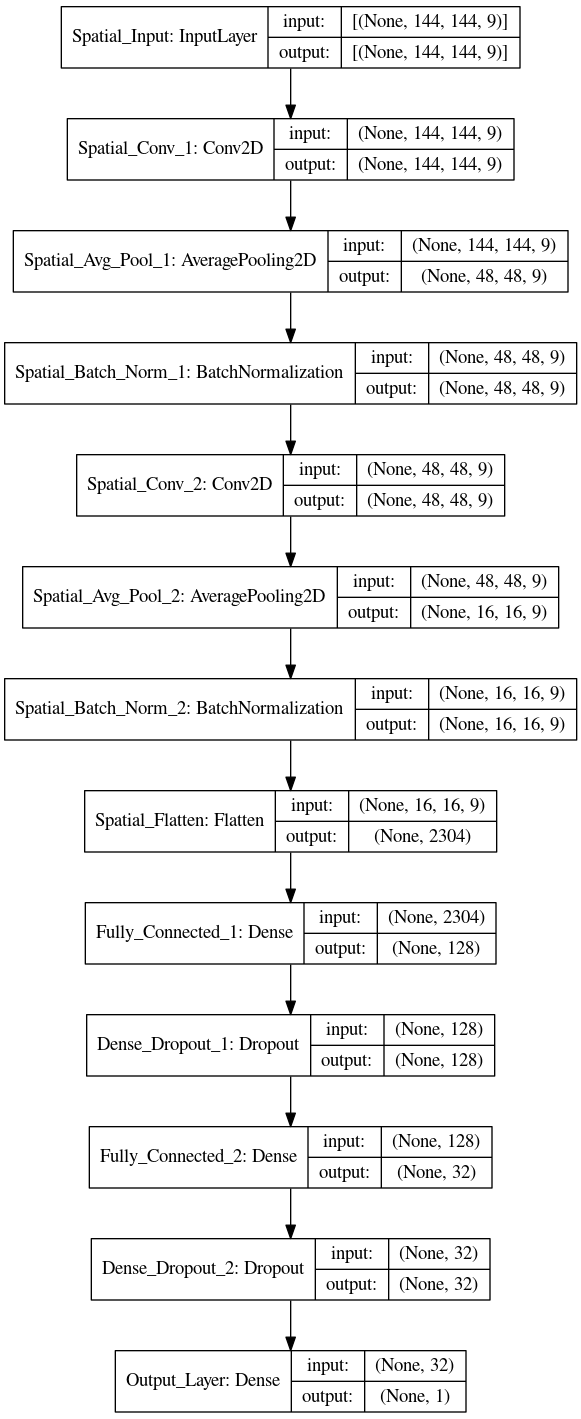

In [15]:
tf.keras.utils.plot_model(model, to_file='dense_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
model.compile(
    loss = keras.losses.BinaryCrossentropy(), 
    optimizer = "adam",
    metrics = ['acc']
)

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='controlmodel.{epoch:02d}-{val_loss:.2f}.h5',
        save_best_only = False
    ),
]

history = model.fit([X_train_spatial], y_train_spatial, 
          batch_size = 5, 
          epochs = 20, 
          validation_data = ([X_test_spatial], y_test_spatial), 
          callbacks = callbacks
          )



Epoch 1/20
71/71 [==============================] - 48s 667ms/step - loss: 1.1185 - acc: 0.5312 - val_loss: 1.8148 - val_acc: 0.5033
Epoch 2/20
71/71 [==============================] - 29s 402ms/step - loss: 0.7678 - acc: 0.5739 - val_loss: 0.6680 - val_acc: 0.5298
Epoch 3/20
71/71 [==============================] - 29s 412ms/step - loss: 0.7251 - acc: 0.5938 - val_loss: 0.6563 - val_acc: 0.5695
Epoch 4/20
71/71 [==============================] - 29s 402ms/step - loss: 0.7606 - acc: 0.5739 - val_loss: 0.6403 - val_acc: 0.5762
Epoch 5/20
71/71 [==============================] - 28s 400ms/step - loss: 0.6426 - acc: 0.6449 - val_loss: 0.6317 - val_acc: 0.6424
Epoch 6/20
71/71 [==============================] - 29s 402ms/step - loss: 0.6254 - acc: 0.6818 - val_loss: 0.5835 - val_acc: 0.6954
Epoch 7/20
71/71 [==============================] - 29s 402ms/step - loss: 0.5508 - acc: 0.6960 - val_loss: 0.5917 - val_acc: 0.7285
Epoch 8/20
71/71 [==============================] - 28s 400ms/step - 

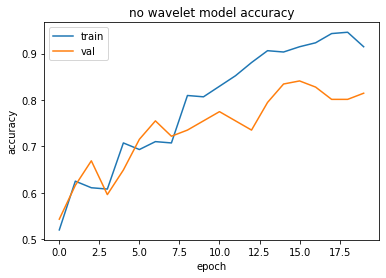

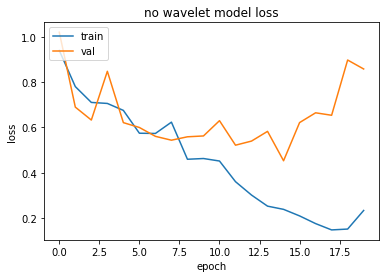

In [50]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('no wavelet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('no wavelet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

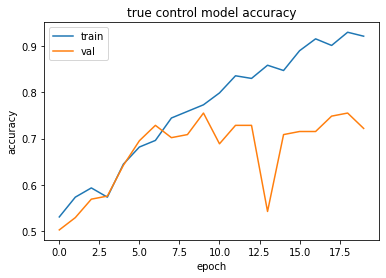

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('true control model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

In [50]:
#model.load_weights('controlmodel.20-0.89.h5')

filename = 'true_control_model_weights'

model.save_weights(filename.format(epoch = 20))

y_pred = model.predict([X_test_spatial])
y_pred_round = np.rint(y_pred)

y_pred_round = y_pred_round.reshape(y_pred_round.shape[0])

print(y_pred_round)

[1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 1.]


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("precision: ", precision_score(y_test_spatial, y_pred_round))
print("recall: ", recall_score(y_test_spatial, y_pred_round))
print("f1 score: ", f1_score(y_test_spatial, y_pred_round))

precision:  0.6736842105263158
recall:  0.8533333333333334
f1 score:  0.7529411764705883


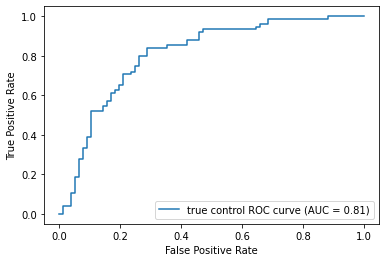

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_spatial, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='true control ROC curve')
display.plot()

plt.show()

In [34]:
def draw_confusion_matrix(y, yhat, classes):
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("true control confusion matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

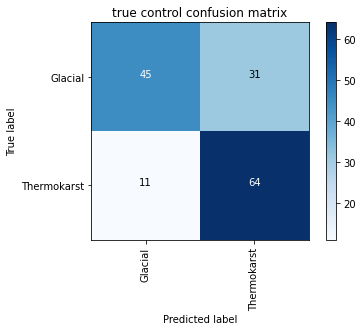

In [35]:
draw_confusion_matrix(y_test_spatial, y_pred_round, ['Glacial', 'Thermokarst'])
fig = plt.ylabel('True label')
fig = plt.xlabel('Predicted label')
fig = plt.show()